In [42]:
# Spark Session, Pipeline, Functions, and Metrics
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import rand
from pyspark.mllib.evaluation import MulticlassMetrics

import pandas as pd

# Keras / Deep Learning
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers, regularizers
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Elephas for Deep Learning on Spark
from elephas.ml_model import ElephasEstimator

In [17]:
from pyspark.sql.functions import *
from pyspark.ml.classification import  RandomForestClassifier
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler, VectorSlicer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.mllib.stat import Statistics
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

In [21]:
conf=SparkConf().setMaster("local")
sc=SparkContext(conf=conf)
sqlContext = SQLContext(sc)

In [20]:
#sc.stop()

In [28]:
data = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('data.csv')
data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- ID: integer (nullable = true)
 |-- Temerrut_flag: integer (nullable = true)
 |-- Basvuru_tarihi: string (nullable = true)
 |-- Kullanim_orani: double (nullable = true)
 |-- Musteri_yasi: integer (nullable = true)
 |-- Dpd_30_adeti: integer (nullable = true)
 |-- Borcun_gelire_orani: double (nullable = true)
 |-- Gelir: double (nullable = true)
 |-- Acik_kredi_sayisi: integer (nullable = true)
 |-- Onceki_temerrut_sayisi: integer (nullable = true)
 |-- Acik_ev_kredi_sayisi: integer (nullable = true)
 |-- Son_2_yil_dpd_31_60_adeti: integer (nullable = true)
 |-- Bakmakla_yukumlu_kisi_sayisi: double (nullable = true)
 |-- Guncel_yil_ort_vdsz_mev_tutari: double (nullable = true)
 |-- Onceki_yil_max_vdsz_mev_tutari: double (nullable = true)
 |-- Onceki_yil_min_vdsz_mev_tutari: double (nullable = true)
 |-- Rotatif_krediler_kullanim_orani: string (nullable = true)
 |-- Kredi_vadesi: string (nullable = true)
 |-- Guncel_yil_gunluk_ort_kk_risk_tuta

In [29]:
drop_list = ['_c0', 'ID', 'Basvuru_tarihi']
data = data.select([column for column in data.columns if column not in drop_list])

In [30]:
from pyspark.sql.functions import col, count, isnan, lit, sum

def count_not_null(c, nan_as_null=False):
    """Use conversion between boolean and integer
    - False -> 0
    - True ->  1
    """
    pred = col(c).isNotNull() & (~isnan(c) if nan_as_null else lit(True))
    return sum(pred.cast("integer")).alias(c)

In [31]:
exprs = [(count_not_null(c) / count("*")).alias(c) for c in data.columns]
completeness = data.agg(*exprs).toPandas()

In [32]:
completeness.to_dict()

{'Temerrut_flag': {0: 1.0},
 'Kullanim_orani': {0: 1.0},
 'Musteri_yasi': {0: 1.0},
 'Dpd_30_adeti': {0: 1.0},
 'Borcun_gelire_orani': {0: 1.0},
 'Gelir': {0: 1.0},
 'Acik_kredi_sayisi': {0: 1.0},
 'Onceki_temerrut_sayisi': {0: 1.0},
 'Acik_ev_kredi_sayisi': {0: 1.0},
 'Son_2_yil_dpd_31_60_adeti': {0: 1.0},
 'Bakmakla_yukumlu_kisi_sayisi': {0: 0.97384},
 'Guncel_yil_ort_vdsz_mev_tutari': {0: 0.7908733333333333},
 'Onceki_yil_max_vdsz_mev_tutari': {0: 0.7909466666666667},
 'Onceki_yil_min_vdsz_mev_tutari': {0: 0.7909733333333333},
 'Rotatif_krediler_kullanim_orani': {0: 0.7896733333333333},
 'Kredi_vadesi': {0: 1.0},
 'Guncel_yil_gunluk_ort_kk_risk_tutari': {0: 0.36102},
 'Guncel_vdsz_mev_tutari': {0: 0.028373333333333334},
 'SGK_kodu': {0: 0.01058},
 'Evin_sahiplik_durumu': {0: 1.0},
 'Istenen_evin_fiyati': {0: 1.0},
 'Toplam_calisma_suresi': {0: 0.2904},
 'Onceki_yil_ort_vdsz_mev_tutari': {0: 0.028373333333333334},
 'Calisma_tipi': {0: 1.0},
 'Son_1_yil_kredi_basvuru_sayisi': {0: 1.0}

In [33]:
drop_list = ['Bakmakla_yukumlu_kisi_sayisi', 'Guncel_yil_ort_vdsz_mev_tutari', 'Onceki_yil_max_vdsz_mev_tutari',
            'Onceki_yil_min_vdsz_mev_tutari', 'Rotatif_krediler_kullanim_orani', 'Guncel_yil_gunluk_ort_kk_risk_tutari',
            'Guncel_vdsz_mev_tutari', 'SGK_kodu', 'Toplam_calisma_suresi', 'Onceki_yil_ort_vdsz_mev_tutari', 'KK_limiti',
            'En_son_calisma_gun_sayisi', 'Isyeri_tel_no']
data = data.select([column for column in data.columns if column not in drop_list])
data.printSchema()

root
 |-- Temerrut_flag: integer (nullable = true)
 |-- Kullanim_orani: double (nullable = true)
 |-- Musteri_yasi: integer (nullable = true)
 |-- Dpd_30_adeti: integer (nullable = true)
 |-- Borcun_gelire_orani: double (nullable = true)
 |-- Gelir: double (nullable = true)
 |-- Acik_kredi_sayisi: integer (nullable = true)
 |-- Onceki_temerrut_sayisi: integer (nullable = true)
 |-- Acik_ev_kredi_sayisi: integer (nullable = true)
 |-- Son_2_yil_dpd_31_60_adeti: integer (nullable = true)
 |-- Kredi_vadesi: string (nullable = true)
 |-- Evin_sahiplik_durumu: string (nullable = true)
 |-- Istenen_evin_fiyati: integer (nullable = true)
 |-- Calisma_tipi: integer (nullable = true)
 |-- Son_1_yil_kredi_basvuru_sayisi: integer (nullable = true)
 |-- Son_6_ay_kredi_basvuru_sayisi: integer (nullable = true)
 |-- Son_3_ay_kredi_basvuru_sayisi: integer (nullable = true)
 |-- Son_2_yil_kabul_edilmis_kredi_sayisi: integer (nullable = true)
 |-- Son_1_yil_kabul_edilmis_kredi_sayisi: integer (nullable

<div class="alert alert-block alert-info">
<b>Step 8:</b> DENEME
</div>

In [15]:
#deneme=["Temerrut_flag","Musteri_yasi","Dpd_30_adeti"]
#data = data.select([column for column in data.columns if column in deneme])
#data.printSchema()

root
 |-- Temerrut_flag: integer (nullable = true)
 |-- Musteri_yasi: integer (nullable = true)
 |-- Dpd_30_adeti: integer (nullable = true)



<div class="alert alert-block alert-info">
<b>Step 8:</b> DENEME
</div>

In [76]:
df=data.toPandas()

In [77]:
df.drop(["Evin_sahiplik_durumu","Kredi_vadesi"],inplace=True,axis=1)

In [78]:
y=df.Temerrut_flag
X=df.iloc[:,1:]

In [79]:
X.head()

,Kullanim_orani,Musteri_yasi,Dpd_30_adeti,Borcun_gelire_orani,Gelir,Acik_kredi_sayisi,Onceki_temerrut_sayisi,Acik_ev_kredi_sayisi,Son_2_yil_dpd_31_60_adeti,Istenen_evin_fiyati,...,KK_flag,Dissal_kredi_skoru,Evin_yasi,Evin_bulundugu_sok_ort_ev_yasi,Yasadigi_yerin_nufus_yogunlugu,Arac_yasi,Arac_flag,Son_12_ay_kk_kullanim_orani,Son_6_ay_kk_kullanim_orani,Son_3_ay_kk_kullanim_orani
0,0.766127,45,2,0.802982,9120.0,13,0,6,0,959346,...,1,1926,1.198,1.328582,0.018801,12.0,1,0.457661,0.458030,0.496336
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,613856,...,1,1596,1.930,1.962810,0.003541,2.0,1,0.409572,0.401219,0.449076
2,0.658180,38,1,0.085113,3042.0,2,1,0,0,412920,...,0,1802,1.836,2.315196,0.010032,7.0,1,0.386582,0.380851,0.413760
3,0.233810,30,0,0.036050,3300.0,5,0,0,0,978835,...,1,1801,1.196,1.523704,0.008019,12.0,1,0.302338,0.300360,0.312051
4,0.907239,49,1,0.024926,63588.0,7,0,1,0,919228,...,1,1068,1.201,1.556496,0.028663,1.0,1,0.499072,0.490249,0.535611


In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [135]:
#from imblearn.over_sampling import SMOTE
#sm = SMOTE(random_state=2)
#X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

In [173]:
# Number of Classes
nb_classes = len(set(y_train))

# Number of Inputs or Input Dimensions
input_dim = X_train.shape[1]

In [174]:
# Set up Deep Learning Model / Architecture
model = Sequential()
model.add(Dense(256, input_shape=(input_dim,), activity_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(256, activity_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(nb_classes))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

In [175]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 256)               7424      
_________________________________________________________________
activation_18 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_19 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 514       
__________

In [176]:
# Compile your model, choose an appropriate optimizer, loss function and metric to track.

model.compile(optimizer='adam',#'sgd'
             loss='sparse_categorical_crossentropy',
             ) 
             
             
# Train your model, adjust batch size and epochs iteratively. Optionally time your training.
 
import time
start = time.time()
model.fit(X_train, y_train, epochs=10, batch_size=10000) 
end=time.time()
print("training time:", (end-start))

# Test your model on the secluded test set

model.evaluate(X_test, y_test)


Epoch 1/10
100500/100500 [==============================] - 5s 49us/step - loss: 110814943727025.0469
Epoch 2/10
100500/100500 [==============================] - 3s 26us/step - loss: 78045886682860.9062
Epoch 3/10
100500/100500 [==============================] - 3s 26us/step - loss: 60295038651498.9844
Epoch 4/10
100500/100500 [==============================] - 3s 26us/step - loss: 46753759491535.6016
Epoch 5/10
100500/100500 [==============================] - 3s 26us/step - loss: 36276993868672.6406
Epoch 6/10
100500/100500 [==============================] - 3s 26us/step - loss: 28114870018659.3438
Epoch 7/10
100500/100500 [==============================] - 3s 25us/step - loss: 21683319133036.2578
Epoch 8/10
100500/100500 [==============================] - 3s 26us/step - loss: 16670085539789.0527
Epoch 9/10
100500/100500 [==============================] - 3s 26us/step - loss: 12761769243785.5527
Epoch 10/10
100500/100500 [==============================] - 3s 26us/step - loss: 97239069

23520042976.059475

In [177]:
df.head()

,Temerrut_flag,Kullanim_orani,Musteri_yasi,Dpd_30_adeti,Borcun_gelire_orani,Gelir,Acik_kredi_sayisi,Onceki_temerrut_sayisi,Acik_ev_kredi_sayisi,Son_2_yil_dpd_31_60_adeti,...,KK_flag,Dissal_kredi_skoru,Evin_yasi,Evin_bulundugu_sok_ort_ev_yasi,Yasadigi_yerin_nufus_yogunlugu,Arac_yasi,Arac_flag,Son_12_ay_kk_kullanim_orani,Son_6_ay_kk_kullanim_orani,Son_3_ay_kk_kullanim_orani
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,...,1,1926,1.198,1.328582,0.018801,12.0,1,0.457661,0.458030,0.496336
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,...,1,1596,1.930,1.962810,0.003541,2.0,1,0.409572,0.401219,0.449076
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,...,0,1802,1.836,2.315196,0.010032,7.0,1,0.386582,0.380851,0.413760
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,...,1,1801,1.196,1.523704,0.008019,12.0,1,0.302338,0.300360,0.312051
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,...,1,1068,1.201,1.556496,0.028663,1.0,1,0.499072,0.490249,0.535611


In [178]:
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal', input_dim=input_dim))
#Second  Hidden Layer
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
#classifier.add(Activation('relu'))
#classifier.add(Dropout(rate=0.3))
#classifier.add(Dense(256, activity_regularizer=regularizers.l2(0.01)))
#classifier.add(Activation('relu'))
#classifier.add(Dropout(rate=0.3))
#classifier.add(Dense(nb_classes))
#classifier.add(Activation('sigmoid'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

In [193]:
#Compiling the neural network
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

In [195]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 4)                 116       
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 5         
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [196]:
#Fitting the data to the training dataset
classifier.fit(X_train,y_train, batch_size=10000, epochs=10)

Epoch 1/10
100500/100500 [==============================] - 2s 23us/step - loss: 0.2595 - acc: 0.9326
Epoch 2/10
100500/100500 [==============================] - 0s 2us/step - loss: 0.2576 - acc: 0.9326
Epoch 3/10
100500/100500 [==============================] - 0s 2us/step - loss: 0.2575 - acc: 0.9326
Epoch 4/10
100500/100500 [==============================] - 0s 2us/step - loss: 0.2569 - acc: 0.9326
Epoch 5/10
100500/100500 [==============================] - 0s 2us/step - loss: 0.2567 - acc: 0.9326
Epoch 6/10
100500/100500 [==============================] - 0s 2us/step - loss: 0.2577 - acc: 0.9326
Epoch 7/10
100500/100500 [==============================] - 0s 2us/step - loss: 0.2559 - acc: 0.9326
Epoch 8/10
100500/100500 [==============================] - 0s 2us/step - loss: 0.2551 - acc: 0.9326
Epoch 9/10
100500/100500 [==============================] - 0s 2us/step - loss: 0.2545 - acc: 0.9326
Epoch 10/10
100500/100500 [==============================] - 0s 2us/step - loss: 0.2541 - 

In [181]:
df.Temerrut_flag.value_counts()

0    139974
1     10026
Name: Temerrut_flag, dtype: int64

In [197]:
y_pred=classifier.predict(X_test)
y_pred =(y_pred>0.5)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[46247     0]
 [ 3253     0]]


In [183]:
len(classifier.predict_proba(X_test))

49500

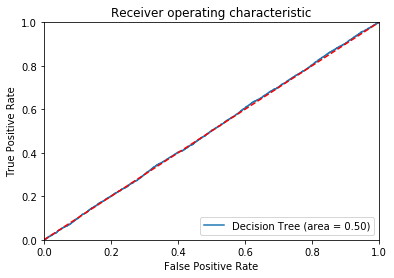

In [184]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test))
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
X_t